In [1]:
from bs4 import BeautifulSoup
from urllib.request import urlopen
import pandas as pd
from datetime import datetime as dt
import numpy as np
pd.options.mode.chained_assignment = None
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
def parse_html(mta_url):
    """
    Parse html data from mta url (http://web.mta.info/developers/turnstile.html')
    """
    umta = urlopen(mta_url)
    mta_page = umta.read()
    
    # parse html data
    mta_html = BeautifulSoup(mta_page, 'html.parser')
    umta.close()
    return mta_html

In [3]:
def get_data_links(mta_html):
    """
    From parsed html data, extract the links to the turnstile datasets
    """
    data = mta_html.findAll('div', attrs = {'class': 'span-84 last'})
    data_links = []
    for div in data:
        links = div.findAll('a')
        for l in links:
            data_links.append(l['href'])
    return data_links

In [4]:
def read_turnstile_before_141018(data_link):
    """
    Read turnstile dataset
    """

    col_names = ["C/A","UNIT","SCP","DATE1","TIME1","DESC1","ENTRIES1",
             "EXITS1","DATE2","TIME2","DESC2","ENTRIES2","EXITS2",
             "DATE3","TIME3","DESC3","ENTRIES3","EXITS3","DATE4",
             "TIME4","DESC4","ENTRIES4","EXITS4","DATE5","TIME5",
             "DESC5","ENTRIES5","EXITS5","DATE6","TIME6","DESC6",
             "ENTRIES6","EXITS6","DATE7","TIME7","DESC7","ENTRIES7",
             "EXITS7","DATE8","TIME8","DESC8","ENTRIES8","EXITS8"]
    
    parsed_df = pd.read_csv('http://web.mta.info/developers/' + 
                            data_link, header = None, names = col_names)
    return parsed_df

In [5]:
def read_remote_booth_station():
    """
    Read in 'Remote-Booth-Station.xls' dataset downloaded from the website
    """
    remote_booth_station_path = "~/Downloads/Remote-Booth-Station.xls"
    remote_booth_station = pd.read_excel(remote_booth_station_path)
    remote_booth_station.columns = ['UNIT', 'C/A', 'STATION', 'LINE_NAME', 'DIVISION']
    

    return remote_booth_station

In [6]:
remote_booth_station = read_remote_booth_station()

### Q1. Which station has the most number of units as of today?

In [7]:
def station_unit_after_141018(link):
    """
    Read turnstile data using specified link from the website. 
    Store station (key) and units (value) in a dictionary.
    """
    station_unit = {}
    
    data_txt= 'http://web.mta.info/developers/' + link
    data = urlopen(data_txt)

    for l in data:
        line = str(l.decode("utf-8").strip(' \n\t')).split(',')
        
        unit = line[1]
        station = line[3]

        if unit == 'UNIT':
            continue
        elif (station in station_unit):
            station_unit[station].add(unit)
        else:
            station_unit[station] = set([unit])
            
    return station_unit

In [8]:
def count_unique_units(station_unit):
    """
    Count the unique number of units for each station.
    """
    counts = {key: len(value) for key, value in 
              station_unit.items()}
    return counts

In [9]:
def top_station(station_unit):
    """
    Return top station with the most units.
    """
    station_unit_180324_count = count_unique_units(station_unit)
    output = sorted(station_unit_180324_count.items(), 
                    key = lambda x: x[1], reverse = True)[0]
    return output

In [10]:
mta_url = 'http://web.mta.info/developers/turnstile.html'

mta_html = parse_html(mta_url)
data_links = get_data_links(mta_html)
station_unit = station_unit_after_141018(data_links[0])

In [11]:
top_station(station_unit)

('23 ST', 6)

**Result:** '23 ST' station has the most number of units as of today.

**Method:** The assumption is that the lastest data is representative of all of MTA's activities. 
1. Read the data from the webpage and storing it in a dictionary with the key as station and value as unit - *station_unit_after_141018(link)*  
2. Count the number of unique units in each station - *count_unique_units(station_unit)*    
3. Return the station with the most unique units - *top_station(station_unit)*

### Q2. What is the total number of entries & exits across the subway system for August 1, 2013?

In [12]:
def read_2013_data(data_links):
    """
    Read in all of 2013 datasets.
    """
    links_2013 = [link for link in data_links if '_13' in link]
    all_2013_df_list = [read_turnstile_before_141018(link) for link in links_2013]
    all_2013_df = pd.concat(all_2013_df_list)
    
    return all_2013_df

In [13]:
def get_stacked_datasets(all_2013_df):
    """
    The dataset has the following columns: 
    C/A,UNIT,SCP,DATE1,TIME1,DESC1,ENTRIES1,EXITS1,DATE2,
    TIME2,DESC2,ENTRIES2,EXITS2,DATE3,TIME3,DESC3,ENTRIES3,
    EXITS3,DATE4,TIME4,DESC4,ENTRIES4,EXITS4,DATE5,TIME5,
    DESC5,ENTRIES5,EXITS5,DATE6,TIME6,DESC6,ENTRIES6,
    EXITS6,DATE7,TIME7,DESC7,ENTRIES7,EXITS7,DATE8,
    TIME8,DESC8,ENTRIES8,EXITS8. Reformat the data such that
    DATE, TIME, DESC, ENTRIES, EXITS are stacked on top of 
    each other.
    """
    columns = all_2013_df.columns
    data_by_idx = []
    for i in range(1, 9):
        col_subset = columns[[str(i) in col for col in columns]]
        dat = all_2013_df[col_subset]
        dat.columns = ['DATE', 'TIME', 'DESC', 'ENTRIES', 'EXITS']
        data_by_idx.append(dat)
    return data_by_idx

In [14]:
def reformat_stacked_datasets(all_2013_df):
    """
    Combine stacked datasets from 'get_stacked_datasets' with
    'C/A', UNIT, and SCP data.
    """
    
    data_by_idx = get_stacked_datasets(all_2013_df)
    all_data_by_idx = pd.concat(data_by_idx, axis = 0, ignore_index = True)
    ca_unit = pd.concat([all_2013_df.iloc[:, :3]]*8, ignore_index = True)
    proc_df = pd.concat([ca_unit, all_data_by_idx], axis = 1)

    return proc_df

In [15]:
def merge_stacked_remote_clean(proc_df, remote_booth_station):
    """
    Merge the stacked dataset to remote-booth-station to get 
    station names. Remove duplicates and missing values (only 
    1.82% of data). Create datetime and turnstile columns.
    """
    
    merge_proc_df = proc_df.merge(remote_booth_station, 
                                  how = 'left', 
                                  on = ['UNIT', 'C/A'])
    merge_proc_df = merge_proc_df.drop_duplicates()
    
    merged_proc_dropped_na = merge_proc_df.dropna()
    
    date = merged_proc_dropped_na.DATE.astype(str) 
    time = merged_proc_dropped_na.TIME.astype(str)

    merged_proc_dropped_na['DATETIME'] = (date + ' ' + time)
    
    merged_proc_dropped_na['TURNSTILE'] = (merged_proc_dropped_na['C/A'] + '_' +
                                       merged_proc_dropped_na['UNIT'] + '_' +
                                       merged_proc_dropped_na['SCP'])
    
    return merged_proc_dropped_na

In [16]:
def sort_diff(df):
    """
    The current extrie and exit values are not in counts, 
    get counts by using pd.Series.diff().
    """
    sorted_df = df.sort_values('DATETIME')
    sorted_df['ENTRIES_DIFF'] = sorted_df.ENTRIES.diff()
    sorted_df['EXITS_DIFF'] = sorted_df.EXITS.diff()
    return sorted_df

In [17]:
def fill_na_neg_zero(df):
    """
    Fill in missing and negative values with zero. 
    Negative values mean that it took the difference 
    of the opening data and the previous closing data.
    """
    df['ENTRIES_DIFF'][df['ENTRIES_DIFF'].isnull()] = 0
    df['ENTRIES_DIFF'][df['ENTRIES_DIFF']<0] = 0
    
    df['EXITS_DIFF'][df['EXITS_DIFF'].isnull()] = 0
    df['EXITS_DIFF'][df['EXITS_DIFF']<0] = 0
    
    return df

In [18]:
def process_sorted_diff_df_2013(data_links):
    """
    Process the data using the functions above.
    """
    
    all_2013_df = read_2013_data(data_links)
    proc_df = reformat_stacked_datasets(all_2013_df)
    merged_proc_dropped_na = merge_stacked_remote_clean(proc_df, remote_booth_station)
    
    grouped = merged_proc_dropped_na.groupby('TURNSTILE')
    sorted_diff_df = grouped.apply(lambda x: sort_diff(x)).reset_index(drop = True)
    
    proc_sorted_diff_df = fill_na_neg_zero(sorted_diff_df)

    return proc_sorted_diff_df

In [19]:
def filter_outliers(proc_sorted_diff_df):
    """
    Remove outliers that are above 99.99 percentile of 
    entries_diff.
    """
    outlier_threshold = np.percentile(proc_sorted_diff_df['ENTRIES_DIFF'], 99.99)
    proc_sorted_diff_df = proc_sorted_diff_df[proc_sorted_diff_df <=outlier_threshold]

    return proc_sorted_diff_df

In [20]:
proc_sorted_diff_df = process_sorted_diff_df_2013(data_links)

In [21]:
proc_sorted_diff_df[['ENTRIES_DIFF', 'EXITS_DIFF']].describe()

,ENTRIES_DIFF,EXITS_DIFF
count,1.125958e+07,1.125958e+07
mean,2.083340e+03,1.546934e+03
std,8.619143e+05,8.719271e+05
min,0.000000e+00,0.000000e+00
25%,2.000000e+00,1.000000e+00
50%,5.200000e+01,3.700000e+01
75%,2.100000e+02,1.450000e+02
max,9.314769e+08,9.719247e+08


From the distribution, we can see that there are extreme values (the maximum). 
We alleviate this by removing values that are above 99.99 percentile.

In [22]:
proc_sorted_diff_df = filter_outliers(proc_sorted_diff_df)

In [23]:
proc_sorted_diff_df[['ENTRIES_DIFF', 'EXITS_DIFF']].describe()

,ENTRIES_DIFF,EXITS_DIFF
count,1.125846e+07,1.125809e+07
mean,1.575224e+02,1.232495e+02
std,2.505864e+02,2.240142e+02
min,0.000000e+00,0.000000e+00
25%,2.000000e+00,1.000000e+00
50%,5.200000e+01,3.700000e+01
75%,2.100000e+02,1.450000e+02
max,3.524000e+03,3.524000e+03


After the outliers are removed, we can see  that there aren't any extreme values.

In [24]:
aug_first = proc_sorted_diff_df[proc_sorted_diff_df.DATE == '08-01-13']
aug_first_entries_exits = aug_first.ENTRIES_DIFF.sum() + aug_first.EXITS_DIFF.sum()

In [25]:
aug_first_entries_exits

9887974.0

**Result:** There are 9,887,974 total number of entries & exits across the subway system for August 1, 2013.

**Method:**  
1. Data ingestion (read all of 2013 data) - *read_2013_data(data_links)*  
2. Process and clean - *process_sorted_diff_df_2013(data_links)*  
3. Subset processed data by august 1 and sum the busyness

### Let’s define the busy-ness as sum of entry & exit count. What station was the busiest on August 1, 2013? What turnstile was the busiest on that date?

In [26]:
aug_first['BUSYNESS'] = aug_first.ENTRIES_DIFF + aug_first.EXITS_DIFF

In [27]:
def top_busyness(df, var):
    """
    Sum the busyness by a given variable and return the busiest.
    """
    df_busy = df.groupby(var)['BUSYNESS'].sum()
    output = df_busy.sort_values(ascending = False).index[0]
    
    return output

In [28]:
top_busyness(aug_first, 'STATION')

'34 ST-PENN STA'

In [29]:
top_busyness(aug_first, 'TURNSTILE')

'R249_R179_01-00-09'

**Results:** The busiest station is '34 ST-PENN STA'. The busiest turnstile have the following information: C/A = R249, UNIT = R179, SCP = 01-00-09.

### What stations have seen the most usage growth/decline in 2013?

In [30]:
proc_sorted_diff_df['MONTH'] = [date[:2] for date in proc_sorted_diff_df.DATE]

In [31]:
proc_sorted_diff_df['BUSYNESS'] = proc_sorted_diff_df.ENTRIES_DIFF + proc_sorted_diff_df.EXITS_DIFF

In [32]:
station_month_busy = proc_sorted_diff_df.groupby(['STATION', 
                             'MONTH'])['BUSYNESS'].mean().reset_index()
station_month_busy.MONTH = station_month_busy.MONTH.astype(float)

In [33]:
def slope_mon_busyness(df):
    """
    Compute slope of month and busyness
    """
    x = df['MONTH']
    y = df['BUSYNESS']
    x_bar = np.mean(x)
    y_bar = np.mean(y)
    
    slope = sum((y-y_bar)*(x-x_bar))/(np.square(x - np.mean(x)).sum() + 1e-4)

    return slope

In [34]:
station_monthly_trend = station_month_busy.groupby(
    'STATION').apply(
    slope_mon_busyness)

In [35]:
sorted_station_month_busy = station_monthly_trend.sort_values(
    ascending = False).index

In [36]:
sorted_station_month_busy[0]

'E TREMONT AVE'

In [37]:
sorted_station_month_busy[-1]

'DYCKMAN ST'

**Result:** The station that has the most growth in 2013 is 'E TREMONT AVE' and the station with a decline growth is 'DYCKMAN ST'. 

**Method:**  
1. Take the average of 'busyness' by month and station.  
2. Find the average growth or decline of station for each increase in month. The slope was used to estimate this relationship. 

### What dates in 2013 are the least busy? Could you identify days in 2013 on which stations were not operating at full capacity or closed entirely?

In [38]:
date_busyness = proc_sorted_diff_df.groupby(
    'DATE')['BUSYNESS'].mean()

In [39]:
least_busy_dates = date_busyness.sort_values(ascending = False).index[-3:].tolist()
least_busy_dates.reverse()

In [40]:
date_busyness_df = date_busyness.reset_index()
date_busyness_df['DATE'] = pd.to_datetime(date_busyness_df['DATE'], infer_datetime_format = True)
date_busyness_df['WEEKDAY'] = date_busyness_df.DATE.dt.weekday_name

In [41]:
least_busy_dates

['12-25-13', '01-01-13', '02-24-13']

In [42]:
date_busyness_df.groupby('WEEKDAY')['BUSYNESS'].mean().sort_values()

WEEKDAY
Sunday       172.080379
Saturday     211.466079
Monday       295.533157
Tuesday      314.884672
Thursday     319.436234
Friday       321.234281
Wednesday    322.787801
Name: BUSYNESS, dtype: float64

**Results:** The least busy dates in 2013 are: December 25, January 1st, and February 24. The days that are not operating at full capacity are Saturday and Sunday. 

**Method**:  
1. Average busyness by date and sort the least three busy dates.  
3. Average busyness by weekday and sort the least busy weekdays.

### Plot the daily row counts for data files in Q3 2013.

In [43]:
# Quarter 3 is defined as the months of July, August, and September. 

df_Q3 = proc_sorted_diff_df[(proc_sorted_diff_df.DATE >='07-01-13') & 
                    (proc_sorted_diff_df.DATE <='09-30-13')]

In [44]:
date_counts = df_Q3.DATE.value_counts(sort = False)
sorted_date_counts = date_counts.sort_index()

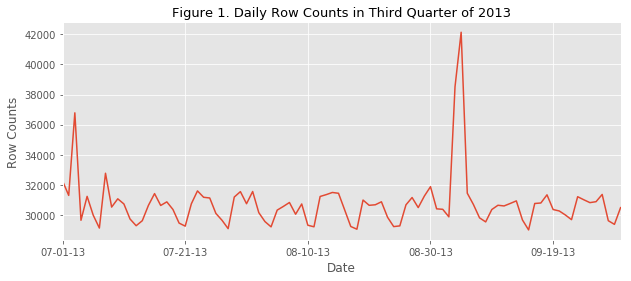

In [45]:
import matplotlib.dates as mdates
plt.style.use(['ggplot'])
ax = sorted_date_counts.plot();
fig = plt.gcf()
fig.set_size_inches(10, 4, forward = True)

plt.xlabel('Date')
plt.ylabel('Row Counts')
plt.title('Figure 1. Daily Row Counts in Third Quarter of 2013', fontsize = 13)

plt.show()

### Plot the daily total number of entries & exits across the system for Q3 2013.

In [46]:
# sum all entries and exits by date
total_entries_exits = df_Q3.groupby('DATE')[[
    'ENTRIES_DIFF', 'EXITS_DIFF']].sum()/(1e6)
total_entries_exits.columns = ['Total Entries', 'Total Exits']

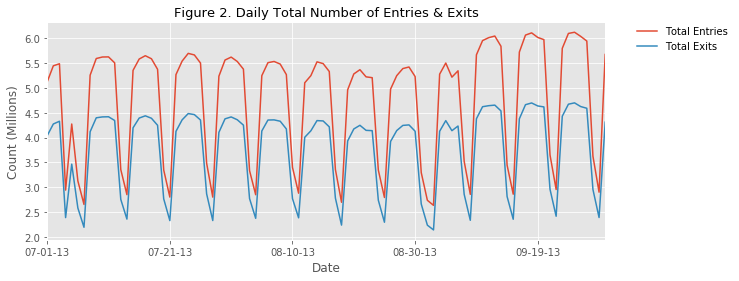

In [47]:
total_entries_exits.plot()
fig = plt.gcf()
fig.set_size_inches(10, 4, forward = True)

leg = plt.legend(bbox_to_anchor=(1.05, 1), 
           loc=2, borderaxespad=0., framealpha = 0)

for text in leg.get_texts():
    plt.setp(text, color = 'k')

plt.xlabel('Date')
plt.ylabel('Count (Millions)')
plt.title('Figure 2. Daily Total Number of Entries & Exits', fontsize = 13)

plt.show()

### Plot the mean and standard deviation of the daily total number of entries & exits for each month in Q3 2013 for station 34 ST-PENN STA.

In [48]:
# subset the data by '34 ST-PENN STA'
df_Q3_penn = df_Q3[df_Q3['STATION'] == '34 ST-PENN STA']

In [49]:
# sum all entries and exits by date
total_entries_exits_penn = df_Q3_penn.groupby('DATE')[[
    'ENTRIES_DIFF', 'EXITS_DIFF']].sum()
total_entries_exits_penn.columns = ['Total Entries', 'Total Exits']

# extract month from date
total_entries_exits_penn['MONTH'] = pd.to_datetime(
    total_entries_exits_penn.index).month

In [50]:
# compute mean and standard deviation by month
grouped = total_entries_exits_penn.groupby('MONTH')
mean_entries = grouped['Total Entries'].mean()
sd_entries = grouped['Total Entries'].std()

mean_exits = grouped['Total Exits'].mean()
sd_exits = grouped['Total Exits'].std()

In [51]:
mean_sd_df = pd.DataFrame([mean_entries, sd_entries, mean_exits, sd_exits]).T
mean_sd_df.columns = ['Mean_Entries', 'Sd_Entries', 
                      'Mean_Exits', 'Sd_Exits']
mean_sd_df = mean_sd_df.reset_index()

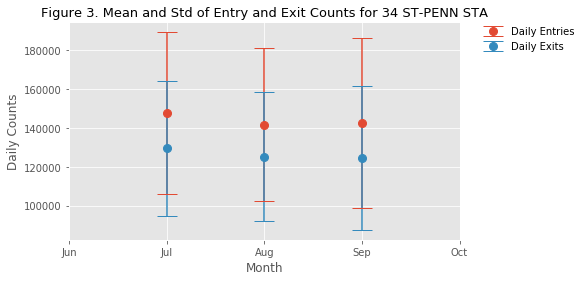

In [52]:
fig = plt.gcf()
fig.set_size_inches(7, 4, forward = True)

plt.errorbar(mean_sd_df['MONTH'],
             mean_sd_df['Mean_Entries'],
             mean_sd_df['Sd_Entries'], 
             fmt = 'o', 
             markersize = 8, 
             capsize = 10, 
             label = 'Daily Entries')

plt.errorbar(mean_sd_df['MONTH'],
             mean_sd_df['Mean_Exits'],
             mean_sd_df['Sd_Exits'], 
             fmt = 'o', 
             markersize = 8, 
             capsize = 10, 
             label = 'Daily Exits')

leg = plt.legend(bbox_to_anchor=(1.05, 1), 
           loc=2, borderaxespad=0., framealpha = 0)

for text in leg.get_texts():
    plt.setp(text, color = 'k')
    
plt.xticks([6,7,8,9, 10], ['Jun','Jul', 'Aug', 'Sep', 'Oct'])
plt.xlabel('Month')
plt.ylabel('Daily Counts')
plt.title('Figure 3. Mean and Std of Entry and Exit Counts for 34 ST-PENN STA',
         fontsize = 13)
plt.show()

### Plot 25/50/75 percentile of the daily total number of entries & exits for each month in Q3 2013 for station 34 ST-PENN STA.

In [53]:
def prep_box_dat(total_entries_exits_penn, var):
    """
    Reformat the data with each row corresponding to the daily 
    sum of entries/exits for that month.
    """
    df_box = []
    for m in [7,8,9]:
        df_box.append(total_entries_exits_penn[var][
            total_entries_exits_penn.MONTH == m].reset_index(drop = True))
    df_mon = pd.concat(df_box, axis = 1)
    df_mon = df_mon.dropna().T
    
    return df_mon

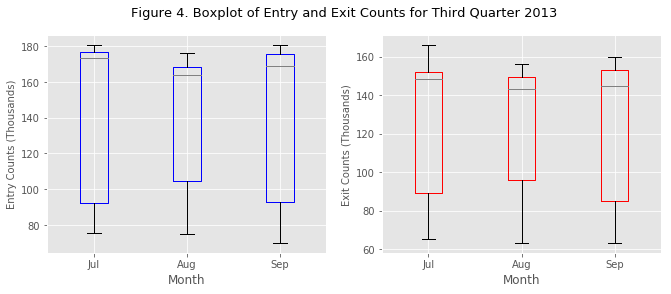

In [54]:
# boxplots

fig = plt.gcf()
fig.set_size_inches(11, 4, forward = True)

plt.subplot(1, 2, 1)

bp1 = plt.boxplot(prep_box_dat(total_entries_exits_penn, 'Total Entries')/1000)

for box in bp1['boxes']:
    box.set(color = 'b')
    
for median in bp1['medians']:
    median.set(color = 'gray')
plt.xlabel('Month')
plt.ylabel('Entry Counts (Thousands)', fontsize = 10)
plt.xticks([1, 2, 3], ['Jul', 'Aug', 'Sep'])

plt.subplot(1, 2, 2)

bp2 = plt.boxplot(prep_box_dat(total_entries_exits_penn, 'Total Exits')/1000)

for box in bp2['boxes']:
    box.set(color = 'r')

for median in bp2['medians']:
    median.set(color = 'gray')

plt.xlabel('Month')
plt.ylabel('Exit Counts (Thousands)', fontsize = 10)
plt.xticks([1, 2, 3], ['Jul', 'Aug', 'Sep'])

plt.suptitle('Figure 4. Boxplot of Entry and Exit Counts for Third Quarter 2013', 
             fontsize = 13)
plt.show()


### Plot the daily number of closed stations and number of stations that were not operating at full capacity in Q3 2013.

In [55]:
closed_df_Q3 = df_Q3[df_Q3.DESC == 'DOOR CLOSE']

In [56]:
"""
The closed and low capacity busy-ness thresholds were arbitrarily set. 
The closed threshold was set by subsetting the quarter 3 data by 'DOOR CLOSED' 
and using the 90th percentile. The low capacity threshold was set by 25th 
percentile of quarter 3 busy-ness.
"""
closed_thresh = np.percentile(closed_df_Q3.BUSYNESS.dropna(), 90)
closed_df_Q3 = closed_df_Q3[closed_df_Q3<=closed_thresh]
print(closed_thresh)

7.0


In [57]:
low_cap_thresh = np.percentile(df_Q3['BUSYNESS'].dropna(), 25)
low_cap_df_Q3 = df_Q3[(df_Q3.BUSYNESS <= low_cap_thresh)&
                     (df_Q3.BUSYNESS >= closed_thresh)]
print(low_cap_thresh)

10.0


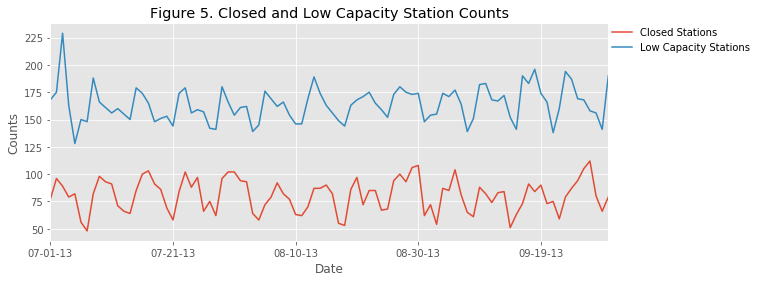

In [58]:
fig = plt.gcf()
fig.set_size_inches(10, 4, forward = True)


closed_df_Q3.groupby('DATE')['STATION'].nunique().plot(label = 'Closed Stations')
low_cap_df_Q3.groupby('DATE')['STATION'].nunique().plot(label = 'Low Capacity Stations')

leg = plt.legend(bbox_to_anchor=(1.0, 1), 
           loc=2, borderaxespad=0., framealpha = 0)

for text in leg.get_texts():
    plt.setp(text, color = 'k')
plt.xlabel('Date')
plt.ylabel('Counts')
plt.title('Figure 5. Closed and Low Capacity Station Counts')
plt.show()